# Dynamic Attention Model (AM-D) Custom Execution

This notebook contains code as I explore and test the implementation created by Eremeev and Pustynnikov.

In [1]:
from attention_dynamic_model import AttentionDynamicModel
import tensorflow as tf

2022-10-17 12:04:35.216348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
%env TF_GPU_ALLOCATOR=cuda_malloc_async

Num GPUs Available:  1
env: TF_GPU_ALLOCATOR=cuda_malloc_async


2022-10-17 12:04:36.595630: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 12:04:36.627240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 12:04:36.627412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Documentation on the AttentionDynamicModel class

The AttentionDynamicModel class is the main model class that implements the AM-D model.

### The constructor

The constructor of the class will set up the basic attributes of the model as well as all the layers. For the encoder and decoder module, a separate class exists for the encoder, but the decoder is implemented inside this model.
```python
def __init__(self,
             embedding_dim, 
             n_encode_layers=2, 
             n_heads=8, 
             tanh_clipping=10): ...
```
| Parameter | Description |
|:---:|:---|
| embedding_dim | The cardinality of the output produced by the embedding projection. This is used to set define the input to the encoder module as well as for the input of the decoder module. |
| n_encode_layers | Number of encoder modules stacked |
| n_heads | Number of heads used by both encoder and decoder attention modules.|
| tanh_clipping | Value used for clipping the attention. |

In [3]:
# AM-D Model Parameters
embedding_dim   = 128
n_encode_layers = 2
n_heads         = 8
tanh_clipping   = 10

model_amd = AttentionDynamicModel(
    embedding_dim  =embedding_dim,
    n_encode_layers=n_encode_layers,
    n_heads        =n_heads,
    tanh_clipping  =tanh_clipping
)

2022-10-17 12:04:39.104824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-17 12:04:39.105248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 12:04:39.105475: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-17 12:04:39.105620: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

#### Setting the Decode Style

There are two types of decoding for AM-D:

1. Greedy
  - Greedy decoding will return the node with the highest probability from the decoder output.
2. Sampling
  - Sampling decoding will return a random node following the random distribution generated by the decoder.

In [4]:
model_amd.set_decode_type('sampling')

### Selecting Optimizer

We have to define an optimizer for the model. See keras' options for this. There are many types to choose from.

#### Adam
```python
tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
    **kwargs
)
```

In [5]:
from tensorflow.keras.optimizers import Adam

# Optimizer Parameters
learning_rate = 0.0001
beta_1        = 0.9
beta_2        = 0.999
epsilon       = 1e-07
amsgrad       = False
name          = "Adam"


optimizer = Adam(
    learning_rate=learning_rate,
    beta_1=beta_1,
    beta_2=beta_2,
    epsilon=epsilon,
    amsgrad=amsgrad,
    name=name,
)

### Creating a Baseline for More Efficient Reinforcement Learning

The AM-D model uses a baseline to help improve the stability of learning. During regular reinforcement learning, it can be challenging to distinguish between actions when the reward obtained may vary based on the state the agent was found on. For example, a set of actions may produce a reward that could be different that the reward obtained starting in a different state that leads to the same end state. This means that the reward variance is high, and it can be hard to compare high reward actions when the initial state is variant. 

To solve this problem, a baseline can be used. In the past, baselines in RL would be a constant value that helps distinguish states based on a "neutral" state that provides information on whether an action is "better or worse." Variance in RL tends to be dependent on the state an agent is found, so we require a dynamic baseline that provides a "neutral" baseline to use for comparing the rewards and reach a referendum easier on what actions are better or worse. There are many different baselines, but for AM-D the best traines AM-D policy is used. If better actions are found that produce better reward, then, the baseline can help see these better actions, based on the best actions learned so far.

#### Rollout Baseline

The Rollout baseline is a type of baseline that uses a ML model that produces the best learned actions so far. Whenever the learned model outperforms the baseline (statistically speaking with T-test) then, the baseline is replaced with the learned model.

__For the AM-D model, a warm up stage can be used for more stable convergance.__ The way this works is that a combination of exponential moving average baseline is used together with the rolling baseline. At the very begining of learning, the policy for the rollout baseline may be too bad to give meaningful baseline costs. To solve this, we can first rely on exponential moving average that utilizes the mean cost obtained by the training model and the average cost is over time is updated by weighting recently-obtained costs higher than previous ones. This also helps in getting through the initial "row" of bad costs obtained by exploration. The Exponential Moving Average (EMA) equation is the following:

$M \leftarrow \beta M + (1-\beta) L(\pi)$

Where $M$ is the moving average and $\beta$ is the weight factor on the importance of previous obtained costs with respect to recent ones. As $\beta$ approaches 0, recent costs are more important and previous costs are forgoten faster. as $\beta$ apptoaches 1.0, previous costs are not as forgoten and remain important to recent average cost. Finding a good balance is important because low $\beta$ will make the average cost be too unstable but high $\beta$ will make the cost depend too much on early outlier costs that may make the cost unstable.

The output cost used for the baseline learning will be a weighted combination of both EMA and rollout baseline. More precisely:

$L(baseline) \leftarrow \alpha L(\pi_g) + (1 - \alpha) M$

Where $\pi_g$ is the rollout baseline used by the algorithm; $\alpha = \frac{epoch + 1}{wp\_n\_epochs}$ is an dynamically-increasing constant from $0.0$ up to $1.0$. $\alpha$ is not allowed to pass $1.0$, and when it does, warm up is deemed complete and only the baseline cost is used.

```python
def __init__(self, 
             model, 
             filename,
             from_checkpoint=False,
             path_to_checkpoint=None,
             wp_n_epochs=1,
             epoch=0,
             num_samples=10000,
             warmup_exp_beta=0.8,
             embedding_dim=128,
             graph_size=20
             ): ...
```

| Parameter           | Description |
| :---:               | :--- |
| model               | Initial ML model to use as baseline |
| filename            | Suffix for checkpoint name for the model (Keras). Model name template is `{path_to_checkpoint}/baseline_checkpoint_epoch_{epoch}_{filename}.h5`|
| from_checkpoint     | Flag to use a saved checkpoint following the suffix provided. |
| path_to_checkpoint  | Directory where to save baseline |
| wp_n_epochs         | Number of warm up epochs |
| epoch               | Starting epoch number |
| num_samples         | Size of dataset generated for baseline. Used when deciding whether current model is statistically better than the baseline. |
| warmup_exp_beta     | weight used during warm up. Balances incorporation of Exponential Moving Average and Rollout Baselines |
| embedding_dim       | used for loading up model. |
| graph_size          | Used for loading up model. |

In [6]:
from reinforce_baseline import RolloutBaseline
from time import strftime, gmtime

model              = model_amd
graph_size         = 20
filename           = 'VRP_{}_{}'.format(graph_size, strftime("%Y-%m-%d", gmtime()))
from_checkpoint    = False
path_to_checkpoint = None
wp_n_epochs        = 5
epoch              = 0
num_samples        = 10_000
warmup_exp_beta    = 0.8
embedding_dim      = embedding_dim


baseline = RolloutBaseline(model             = model,
                           filename          = filename,
                           from_checkpoint   = from_checkpoint,
                           path_to_checkpoint= path_to_checkpoint,
                           wp_n_epochs       = wp_n_epochs,
                           epoch             = epoch,
                           num_samples       = num_samples,
                           embedding_dim     = embedding_dim,
                           graph_size        = graph_size
                           )

Evaluating baseline model on baseline dataset (epoch = 0)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.40it/s]


### Creating Problem Dataset

Dataset generation is provided by the `utils.py` module. The recommended function to generate data is `create_data_on_disk`:

```python
def create_data_on_disk(
    graph_size, 
    num_samples, 
    is_save=True, 
    filename=None, 
    is_return=False, 
    seed=1234): ...

```

| Parameter | Description|
| :---:     | :---       |
| graph_size  | Number of nodes to generate |
| num_samples | Size of dataset |
| is_save     | Flag for saving to disk |
| filename    | Suffix of dataset: 'Validation\_dataset\_{filename}.pkl' |
| is_return   | Whether to return dataset or not |
| seed        | Seed for generation |

Note that the data generated will use the TensorFlow API for datasets.

In [7]:
from utils import create_data_on_disk

graph_size  = graph_size
num_samples = 10_000
is_save     = True
filename    = filename
is_return   = True
seed        = 42

validation_dataset = create_data_on_disk(graph_size =graph_size,
                                         num_samples=num_samples,
                                         is_save    =is_save,
                                         filename   =filename,
                                         is_return  =is_return,
                                         seed       =seed)

#### Vizualization of output data

In [8]:
import pandas as pd
import seaborn as sns

gen_data = next(validation_dataset.batch(6_000).as_numpy_iterator())
sample   = 0
__type   = 1 # 0: space nodes, 1: depot node
graph    = pd.DataFrame(gen_data[__type][sample], columns=['x', 'y'])

goal = {
    'x': gen_data[0][sample][0], 
    'y': gen_data[0][sample][1], 
    'type': 'depot'
}

graph = graph.assign(type='node').append(goal, ignore_index=True)

graph

/tmp/ipykernel_18986/106837068.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  graph = graph.assign(type='node').append(goal, ignore_index=True)


,x,y,type
0,0.090576,0.105941,node
1,0.672503,0.656092,node
2,0.402797,0.798440,node
3,0.893440,0.426028,node
4,0.260078,0.359273,node
5,0.652982,0.425485,node
6,0.080519,0.855694,node
7,0.147657,0.004048,node
8,0.521012,0.173180,node
9,0.042330,0.255430,node


<AxesSubplot: xlabel='x', ylabel='y'>

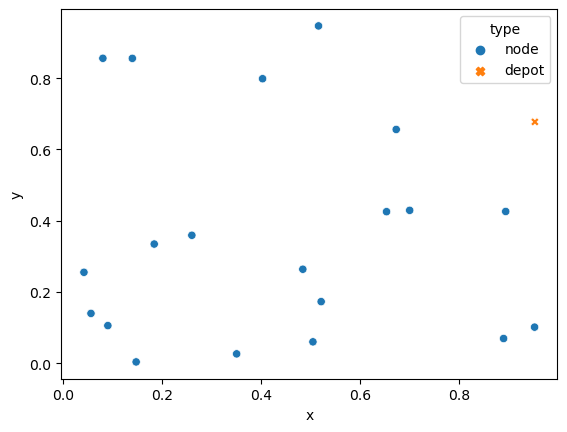

In [9]:
sns.scatterplot(data=graph, x='x', y='y', hue='type', style='type')

### Training the Model

The developers provide a training function for orchestrating the training and rollout process of training.

```python
def train_model(optimizer,
                model_tf,
                baseline,
                validation_dataset,
                samples = 1280000,
                batch = 128,
                val_batch_size = 1000,
                start_epoch = 0,
                end_epoch = 5,
                from_checkpoint = False,
                grad_norm_clipping = 1.0,
                batch_verbose = 1000,
                graph_size = 20,
                filename = None
                ): ...
```

| Parameter          | Description |
| :----------------: | :---------- |
| optimizer          | Optimizer to be used for training |
| model_tf           | Training model to use             |
| baseline           | Initial baseline                  |
| validation_dataset | Generated dataset for validation (used at the end) |
| samples            | Number of samples to use for each learning epoch |
| batch              | Size of batches for learning      |
| val_batch_size     | Number of batches to use for validation (averaged out at the end for final score)|
| start_epoch        | Initial epoch configuration       |
| end_epoch          | Last epoch                        |
| from_checkpoint    | Flag for loading checkpoint       |
| grad_norm_clipping | Clipping/rescaling of gradients   |
| batch_verbose      | Verbosity of output               |
| graph_size         | Number of nodes for graph generated |
| filename           | Suffix of saved model: `VRP_{graph_size}_{date}` |

Current decode type: sampling


batch calculation at epoch 0: 1it [00:01,  1.86s/it]

grad_global_norm = 23.173282623291016, clipped_norm = 1.0
Epoch 0 (batch = 0): Loss: -3.076049327850342: Cost: 13.399057388305664


batch calculation at epoch 0: 16it [00:19,  1.21s/it]


Evaluating candidate model on baseline dataset (callback epoch = 0)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.66it/s]


Epoch 0 candidate mean 9.867398262023926, baseline epoch 0 mean 10.007387161254883, difference -0.13998889923095703
p-value: 1.8849017923769159e-25
Update baseline
Evaluating baseline model on baseline dataset (epoch = 0)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]


alpha was updated to 0.2


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]


Validation score: 9.879400253295898
2022-10-17 12:05:51 Epoch 0: Loss: 8.403587341308594: Cost: 12.758459091186523
Current decode type: sampling


batch calculation at epoch 1: 1it [00:01,  1.50s/it]

grad_global_norm = 4.065773963928223, clipped_norm = 1.0
Epoch 1 (batch = 0): Loss: -10.100244522094727: Cost: 12.215353012084961


batch calculation at epoch 1: 16it [00:23,  1.48s/it]


Evaluating candidate model on baseline dataset (callback epoch = 1)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.69it/s]


Epoch 1 candidate mean 9.85632610321045, baseline epoch 1 mean 9.867846488952637, difference -0.0115203857421875
p-value: 0.08777805091298081
alpha was updated to 0.4


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.70it/s]


Validation score: 9.845000267028809
2022-10-17 12:06:27 Epoch 1: Loss: -4.141163349151611: Cost: 11.635958671569824
Current decode type: sampling


batch calculation at epoch 2: 1it [00:01,  1.46s/it]

grad_global_norm = 6.646369457244873, clipped_norm = 1.0
Epoch 2 (batch = 0): Loss: -8.349431037902832: Cost: 11.038843154907227


batch calculation at epoch 2: 16it [00:23,  1.47s/it]


Evaluating candidate model on baseline dataset (callback epoch = 2)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]


Epoch 2 candidate mean 9.931436538696289, baseline epoch 2 mean 9.867846488952637, difference 0.06359004974365234
alpha was updated to 0.6


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]


Validation score: 9.929699897766113
2022-10-17 12:07:03 Epoch 2: Loss: -2.3272573947906494: Cost: 10.56613540649414
Current decode type: sampling


batch calculation at epoch 3: 1it [00:01,  1.46s/it]

grad_global_norm = 7.057199954986572, clipped_norm = 0.9999999403953552
Epoch 3 (batch = 0): Loss: -2.5809531211853027: Cost: 10.274267196655273


batch calculation at epoch 3: 16it [00:23,  1.46s/it]


Evaluating candidate model on baseline dataset (callback epoch = 3)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.67it/s]


Epoch 3 candidate mean 9.94503116607666, baseline epoch 3 mean 9.867846488952637, difference 0.07718467712402344
alpha was updated to 0.8


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]


Validation score: 9.937100410461426
2022-10-17 12:07:38 Epoch 3: Loss: -1.555439829826355: Cost: 9.992741584777832
Current decode type: sampling


batch calculation at epoch 4: 1it [00:01,  1.52s/it]

grad_global_norm = 15.841002464294434, clipped_norm = 0.9999999403953552
Epoch 4 (batch = 0): Loss: -0.9167354106903076: Cost: 9.887802124023438


batch calculation at epoch 4: 16it [00:23,  1.44s/it]


Evaluating candidate model on baseline dataset (callback epoch = 4)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.67it/s]


Epoch 4 candidate mean 9.93845272064209, baseline epoch 4 mean 9.867846488952637, difference 0.07060623168945312
alpha was updated to 1.0


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.71it/s]


Validation score: 9.934499740600586
2022-10-17 12:08:14 Epoch 4: Loss: -3.4341022968292236: Cost: 10.12353801727295


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.82it/s]


Current decode type: sampling


batch calculation at epoch 5: 1it [00:00,  1.03it/s]

grad_global_norm = 11.06781005859375, clipped_norm = 1.0
Epoch 5 (batch = 0): Loss: -5.935725688934326: Cost: 9.87963581085205


batch calculation at epoch 5: 16it [00:15,  1.03it/s]


Evaluating candidate model on baseline dataset (callback epoch = 5)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.69it/s]


Epoch 5 candidate mean 9.930848121643066, baseline epoch 5 mean 9.867846488952637, difference 0.06300163269042969


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]


Validation score: 9.933799743652344
2022-10-17 12:08:42 Epoch 5: Loss: -3.7520625591278076: Cost: 10.056415557861328


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Current decode type: sampling


batch calculation at epoch 6: 1it [00:00,  1.01it/s]

grad_global_norm = 6.202516555786133, clipped_norm = 1.0
Epoch 6 (batch = 0): Loss: -3.565091609954834: Cost: 10.207012176513672


batch calculation at epoch 6: 16it [00:16,  1.04s/it]


Evaluating candidate model on baseline dataset (callback epoch = 6)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.66it/s]


Epoch 6 candidate mean 9.910632133483887, baseline epoch 6 mean 9.867846488952637, difference 0.04278564453125


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.62it/s]


Validation score: 9.90310001373291
2022-10-17 12:09:12 Epoch 6: Loss: -2.813110589981079: Cost: 10.117076873779297


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Current decode type: sampling


batch calculation at epoch 7: 1it [00:00,  1.01it/s]

grad_global_norm = 10.18561840057373, clipped_norm = 0.9999999403953552
Epoch 7 (batch = 0): Loss: -3.421947956085205: Cost: 10.549947738647461


batch calculation at epoch 7: 16it [00:16,  1.01s/it]


Evaluating candidate model on baseline dataset (callback epoch = 7)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]


Epoch 7 candidate mean 9.855419158935547, baseline epoch 7 mean 9.867846488952637, difference -0.012427330017089844
p-value: 0.10499326137963656


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]


Validation score: 9.853099822998047
2022-10-17 12:09:41 Epoch 7: Loss: -1.3241287469863892: Cost: 10.077676773071289


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Current decode type: sampling


batch calculation at epoch 8: 1it [00:01,  1.01s/it]

grad_global_norm = 7.247410774230957, clipped_norm = 1.0
Epoch 8 (batch = 0): Loss: 1.9065927267074585: Cost: 9.651243209838867


batch calculation at epoch 8: 16it [00:16,  1.02s/it]


Evaluating candidate model on baseline dataset (callback epoch = 8)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]


Epoch 8 candidate mean 9.82608413696289, baseline epoch 8 mean 9.867846488952637, difference -0.041762351989746094
p-value: 0.00014011553111366442
Update baseline
Evaluating baseline model on baseline dataset (epoch = 8)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.58it/s]


Validation score: 9.819100379943848
2022-10-17 12:10:24 Epoch 8: Loss: -0.8465870022773743: Cost: 9.899518966674805


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


Current decode type: sampling


batch calculation at epoch 9: 1it [00:01,  1.04s/it]

grad_global_norm = 22.29892921447754, clipped_norm = 1.0
Epoch 9 (batch = 0): Loss: -3.9956369400024414: Cost: 9.851153373718262


batch calculation at epoch 9: 16it [00:15,  1.03it/s]


Evaluating candidate model on baseline dataset (callback epoch = 9)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch 9 candidate mean 9.804862976074219, baseline epoch 9 mean 9.814566612243652, difference -0.009703636169433594
p-value: 0.09103670705502538


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.71it/s]


Validation score: 9.809900283813477
2022-10-17 12:10:53 Epoch 9: Loss: -1.6530230045318604: Cost: 9.933980941772461


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Current decode type: sampling


batch calculation at epoch 10: 1it [00:00,  1.06it/s]

grad_global_norm = 25.733606338500977, clipped_norm = 0.9999999403953552
Epoch 10 (batch = 0): Loss: -7.106573104858398: Cost: 10.30224895477295


batch calculation at epoch 10: 16it [00:15,  1.02it/s]


Evaluating candidate model on baseline dataset (callback epoch = 10)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]


Epoch 10 candidate mean 9.815462112426758, baseline epoch 10 mean 9.814566612243652, difference 0.0008955001831054688


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.69it/s]


Validation score: 9.810199737548828
2022-10-17 12:11:21 Epoch 10: Loss: -3.4486682415008545: Cost: 9.934718132019043


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.69it/s]


Current decode type: sampling


batch calculation at epoch 11: 1it [00:01,  1.09s/it]

grad_global_norm = 11.584067344665527, clipped_norm = 1.0
Epoch 11 (batch = 0): Loss: -0.6784723401069641: Cost: 9.835627555847168


batch calculation at epoch 11: 16it [00:16,  1.02s/it]


Evaluating candidate model on baseline dataset (callback epoch = 11)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]


Epoch 11 candidate mean 9.81983470916748, baseline epoch 11 mean 9.814566612243652, difference 0.005268096923828125


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.62it/s]


Validation score: 9.819899559020996
2022-10-17 12:11:51 Epoch 11: Loss: -2.7303037643432617: Cost: 9.923032760620117


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Current decode type: sampling


batch calculation at epoch 12: 1it [00:01,  1.03s/it]

grad_global_norm = 26.262386322021484, clipped_norm = 1.0
Epoch 12 (batch = 0): Loss: -4.5397725105285645: Cost: 10.236833572387695


batch calculation at epoch 12: 16it [00:16,  1.01s/it]


Evaluating candidate model on baseline dataset (callback epoch = 12)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.58it/s]


Epoch 12 candidate mean 9.806557655334473, baseline epoch 12 mean 9.814566612243652, difference -0.008008956909179688
p-value: 0.18222100359728816


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.58it/s]


Validation score: 9.816900253295898
2022-10-17 12:12:20 Epoch 12: Loss: -1.4649091958999634: Cost: 9.84946346282959


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.72it/s]


Current decode type: sampling


batch calculation at epoch 13: 1it [00:01,  1.03s/it]

grad_global_norm = 6.873028755187988, clipped_norm = 1.0
Epoch 13 (batch = 0): Loss: -5.857100486755371: Cost: 9.962303161621094


batch calculation at epoch 13: 16it [00:16,  1.00s/it]


Evaluating candidate model on baseline dataset (callback epoch = 13)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch 13 candidate mean 9.845901489257812, baseline epoch 13 mean 9.814566612243652, difference 0.031334877014160156


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.56it/s]


Validation score: 9.847900390625
2022-10-17 12:12:50 Epoch 13: Loss: -4.888605117797852: Cost: 10.10473346710205


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Current decode type: sampling


batch calculation at epoch 14: 1it [00:01,  1.01s/it]

grad_global_norm = 20.7821044921875, clipped_norm = 0.9999999403953552
Epoch 14 (batch = 0): Loss: -1.217819094657898: Cost: 9.83366870880127


batch calculation at epoch 14: 16it [00:16,  1.05s/it]


Evaluating candidate model on baseline dataset (callback epoch = 14)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.65it/s]


Epoch 14 candidate mean 9.837383270263672, baseline epoch 14 mean 9.814566612243652, difference 0.02281665802001953


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.67it/s]


Validation score: 9.841899871826172
2022-10-17 12:13:19 Epoch 14: Loss: -2.4867024421691895: Cost: 9.973196029663086


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


Current decode type: sampling


batch calculation at epoch 15: 1it [00:01,  1.03s/it]

grad_global_norm = 18.40891456604004, clipped_norm = 1.0
Epoch 15 (batch = 0): Loss: -5.838495254516602: Cost: 10.202685356140137


batch calculation at epoch 15: 16it [00:15,  1.02it/s]


Evaluating candidate model on baseline dataset (callback epoch = 15)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]


Epoch 15 candidate mean 9.808028221130371, baseline epoch 15 mean 9.814566612243652, difference -0.00653839111328125
p-value: 0.24545276041453268


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.61it/s]


Validation score: 9.808799743652344
2022-10-17 12:13:48 Epoch 15: Loss: -3.31192946434021: Cost: 9.971243858337402


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Current decode type: sampling


batch calculation at epoch 16: 1it [00:00,  1.07it/s]

grad_global_norm = 6.120670795440674, clipped_norm = 1.0
Epoch 16 (batch = 0): Loss: 0.01716148853302002: Cost: 9.725332260131836


batch calculation at epoch 16: 16it [00:16,  1.05s/it]


Evaluating candidate model on baseline dataset (callback epoch = 16)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.59it/s]


Epoch 16 candidate mean 9.786218643188477, baseline epoch 16 mean 9.814566612243652, difference -0.02834796905517578
p-value: 0.0001888569672573652
Update baseline
Evaluating baseline model on baseline dataset (epoch = 16)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.67it/s]


Validation score: 9.796199798583984
2022-10-17 12:14:32 Epoch 16: Loss: -0.779914140701294: Cost: 9.763375282287598


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


Current decode type: sampling


batch calculation at epoch 17: 1it [00:00,  1.01it/s]

grad_global_norm = 10.605067253112793, clipped_norm = 0.9999999403953552
Epoch 17 (batch = 0): Loss: -4.157285213470459: Cost: 10.454465866088867


batch calculation at epoch 17: 16it [00:16,  1.01s/it]


Evaluating candidate model on baseline dataset (callback epoch = 17)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.61it/s]


Epoch 17 candidate mean 9.791360855102539, baseline epoch 17 mean 9.796137809753418, difference -0.004776954650878906
p-value: 0.2185277616878687


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.67it/s]


Validation score: 9.800000190734863
2022-10-17 12:15:01 Epoch 17: Loss: -2.3796348571777344: Cost: 9.899735450744629


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Current decode type: sampling


batch calculation at epoch 18: 1it [00:01,  1.07s/it]

grad_global_norm = 15.077255249023438, clipped_norm = 0.9999999403953552
Epoch 18 (batch = 0): Loss: -1.2176181077957153: Cost: 10.395288467407227


batch calculation at epoch 18: 16it [00:16,  1.05s/it]


Evaluating candidate model on baseline dataset (callback epoch = 18)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.61it/s]


Epoch 18 candidate mean 9.801107406616211, baseline epoch 18 mean 9.796137809753418, difference 0.004969596862792969


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]


Validation score: 9.809200286865234
2022-10-17 12:15:31 Epoch 18: Loss: -1.4889802932739258: Cost: 10.029624938964844


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Current decode type: sampling


batch calculation at epoch 19: 1it [00:00,  1.01it/s]

grad_global_norm = 8.364154815673828, clipped_norm = 1.0
Epoch 19 (batch = 0): Loss: -2.238406181335449: Cost: 10.148408889770508


batch calculation at epoch 19: 16it [00:16,  1.02s/it]


Evaluating candidate model on baseline dataset (callback epoch = 19)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.60it/s]


Epoch 19 candidate mean 9.812100410461426, baseline epoch 19 mean 9.796137809753418, difference 0.015962600708007812


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.69it/s]


Validation score: 9.839300155639648
2022-10-17 12:16:01 Epoch 19: Loss: -3.5824098587036133: Cost: 10.017873764038086


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.92it/s]


Current decode type: sampling


batch calculation at epoch 20: 1it [00:01,  1.02s/it]

grad_global_norm = 21.954715728759766, clipped_norm = 1.0
Epoch 20 (batch = 0): Loss: -5.2145185470581055: Cost: 10.190801620483398


batch calculation at epoch 20: 16it [00:16,  1.01s/it]


Evaluating candidate model on baseline dataset (callback epoch = 20)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.60it/s]


Epoch 20 candidate mean 9.871421813964844, baseline epoch 20 mean 9.796137809753418, difference 0.07528400421142578


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.59it/s]


Validation score: 9.8818998336792
2022-10-17 12:16:30 Epoch 20: Loss: -2.211606025695801: Cost: 9.904327392578125


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Current decode type: sampling


batch calculation at epoch 21: 1it [00:01,  1.13s/it]

grad_global_norm = 8.362775802612305, clipped_norm = 1.0
Epoch 21 (batch = 0): Loss: 1.271716833114624: Cost: 10.00255012512207


batch calculation at epoch 21: 16it [00:16,  1.05s/it]


Evaluating candidate model on baseline dataset (callback epoch = 21)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.51it/s]


Epoch 21 candidate mean 9.878376007080078, baseline epoch 21 mean 9.796137809753418, difference 0.08223819732666016


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]


Validation score: 9.887900352478027
2022-10-17 12:17:01 Epoch 21: Loss: -3.6773011684417725: Cost: 10.00421142578125


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


Current decode type: sampling


batch calculation at epoch 22: 1it [00:01,  1.12s/it]

grad_global_norm = 9.049680709838867, clipped_norm = 1.0
Epoch 22 (batch = 0): Loss: -2.2980153560638428: Cost: 9.857955932617188


batch calculation at epoch 22: 16it [00:16,  1.01s/it]


Evaluating candidate model on baseline dataset (callback epoch = 22)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]


Epoch 22 candidate mean 9.841436386108398, baseline epoch 22 mean 9.796137809753418, difference 0.04529857635498047


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.71it/s]


Validation score: 9.85789966583252
2022-10-17 12:17:30 Epoch 22: Loss: -3.8318331241607666: Cost: 10.064565658569336


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


Current decode type: sampling


batch calculation at epoch 23: 1it [00:00,  1.02it/s]

grad_global_norm = 6.084665298461914, clipped_norm = 1.0
Epoch 23 (batch = 0): Loss: -0.28887468576431274: Cost: 10.179949760437012


batch calculation at epoch 23: 16it [00:15,  1.03it/s]


Evaluating candidate model on baseline dataset (callback epoch = 23)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.61it/s]


Epoch 23 candidate mean 9.774321556091309, baseline epoch 23 mean 9.796137809753418, difference -0.021816253662109375
p-value: 0.0013552856178681255
Update baseline
Evaluating baseline model on baseline dataset (epoch = 23)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]


Validation score: 9.790399551391602
2022-10-17 12:18:12 Epoch 23: Loss: -1.1843663454055786: Cost: 9.988676071166992


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Current decode type: sampling


batch calculation at epoch 24: 1it [00:01,  1.01s/it]

grad_global_norm = 10.944085121154785, clipped_norm = 1.0
Epoch 24 (batch = 0): Loss: -2.1668310165405273: Cost: 10.366240501403809


batch calculation at epoch 24: 16it [00:16,  1.04s/it]


Evaluating candidate model on baseline dataset (callback epoch = 24)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.59it/s]


Epoch 24 candidate mean 9.784924507141113, baseline epoch 24 mean 9.80090045928955, difference -0.0159759521484375
p-value: 0.058615670606982966


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.67it/s]


Validation score: 9.775799751281738
2022-10-17 12:18:41 Epoch 24: Loss: -1.45815908908844: Cost: 9.953190803527832


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Current decode type: sampling


batch calculation at epoch 25: 1it [00:01,  1.17s/it]

grad_global_norm = 20.28697395324707, clipped_norm = 0.9999998807907104
Epoch 25 (batch = 0): Loss: -2.8646602630615234: Cost: 10.29572582244873


batch calculation at epoch 25: 16it [00:16,  1.02s/it]


Evaluating candidate model on baseline dataset (callback epoch = 25)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.72it/s]


Epoch 25 candidate mean 9.79804801940918, baseline epoch 25 mean 9.80090045928955, difference -0.0028524398803710938
p-value: 0.39269597157952096


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.71it/s]


Validation score: 9.76930046081543
2022-10-17 12:19:10 Epoch 25: Loss: -2.0106430053710938: Cost: 9.891186714172363


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


Current decode type: sampling


batch calculation at epoch 26: 1it [00:01,  1.03s/it]

grad_global_norm = 14.796266555786133, clipped_norm = 1.0
Epoch 26 (batch = 0): Loss: -3.475048542022705: Cost: 10.111724853515625


batch calculation at epoch 26: 16it [00:15,  1.01it/s]


Evaluating candidate model on baseline dataset (callback epoch = 26)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.69it/s]


Epoch 26 candidate mean 9.793057441711426, baseline epoch 26 mean 9.80090045928955, difference -0.007843017578125
p-value: 0.22512703127265088


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.70it/s]


Validation score: 9.765399932861328
2022-10-17 12:19:39 Epoch 26: Loss: -1.647753357887268: Cost: 9.944725036621094


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Current decode type: sampling


batch calculation at epoch 27: 1it [00:00,  1.06it/s]

grad_global_norm = 7.763914108276367, clipped_norm = 1.0
Epoch 27 (batch = 0): Loss: -2.419490098953247: Cost: 9.826383590698242


batch calculation at epoch 27: 16it [00:15,  1.05it/s]


Evaluating candidate model on baseline dataset (callback epoch = 27)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.69it/s]


Epoch 27 candidate mean 9.784379959106445, baseline epoch 27 mean 9.80090045928955, difference -0.01652050018310547
p-value: 0.043347021520285085
Update baseline
Evaluating baseline model on baseline dataset (epoch = 27)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.70it/s]


Validation score: 9.766799926757812
2022-10-17 12:20:20 Epoch 27: Loss: -1.3423062562942505: Cost: 9.951501846313477


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Current decode type: sampling


batch calculation at epoch 28: 1it [00:00,  1.02it/s]

grad_global_norm = 5.720104694366455, clipped_norm = 1.0
Epoch 28 (batch = 0): Loss: -1.680754542350769: Cost: 10.181818962097168


batch calculation at epoch 28: 16it [00:16,  1.00s/it]


Evaluating candidate model on baseline dataset (callback epoch = 28)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch 28 candidate mean 9.765198707580566, baseline epoch 28 mean 9.782282829284668, difference -0.017084121704101562
p-value: 0.0192077320667839
Update baseline
Evaluating baseline model on baseline dataset (epoch = 28)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.70it/s]


Validation score: 9.764699935913086
2022-10-17 12:21:02 Epoch 28: Loss: -1.8349609375: Cost: 9.900467872619629


Rollout greedy execution: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Current decode type: sampling


batch calculation at epoch 29: 1it [00:01,  1.02s/it]

grad_global_norm = 7.622494697570801, clipped_norm = 1.0
Epoch 29 (batch = 0): Loss: -1.2269285917282104: Cost: 9.742823600769043


batch calculation at epoch 29: 16it [00:15,  1.01it/s]


Evaluating candidate model on baseline dataset (callback epoch = 29)


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.69it/s]


Epoch 29 candidate mean 9.759801864624023, baseline epoch 29 mean 9.758708953857422, difference 0.0010929107666015625


Rollout greedy execution: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.71it/s]


Validation score: 9.763899803161621
2022-10-17 12:21:31 Epoch 29: Loss: -1.859117865562439: Cost: 9.865082740783691


/home/joseaguilar/coding/github/DynamicAttentionModel-VRP/utils.py:101: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='epochs', y='val_сost', data=df_test, palette='darkblue', label='val cost').set(ylabel='cost')


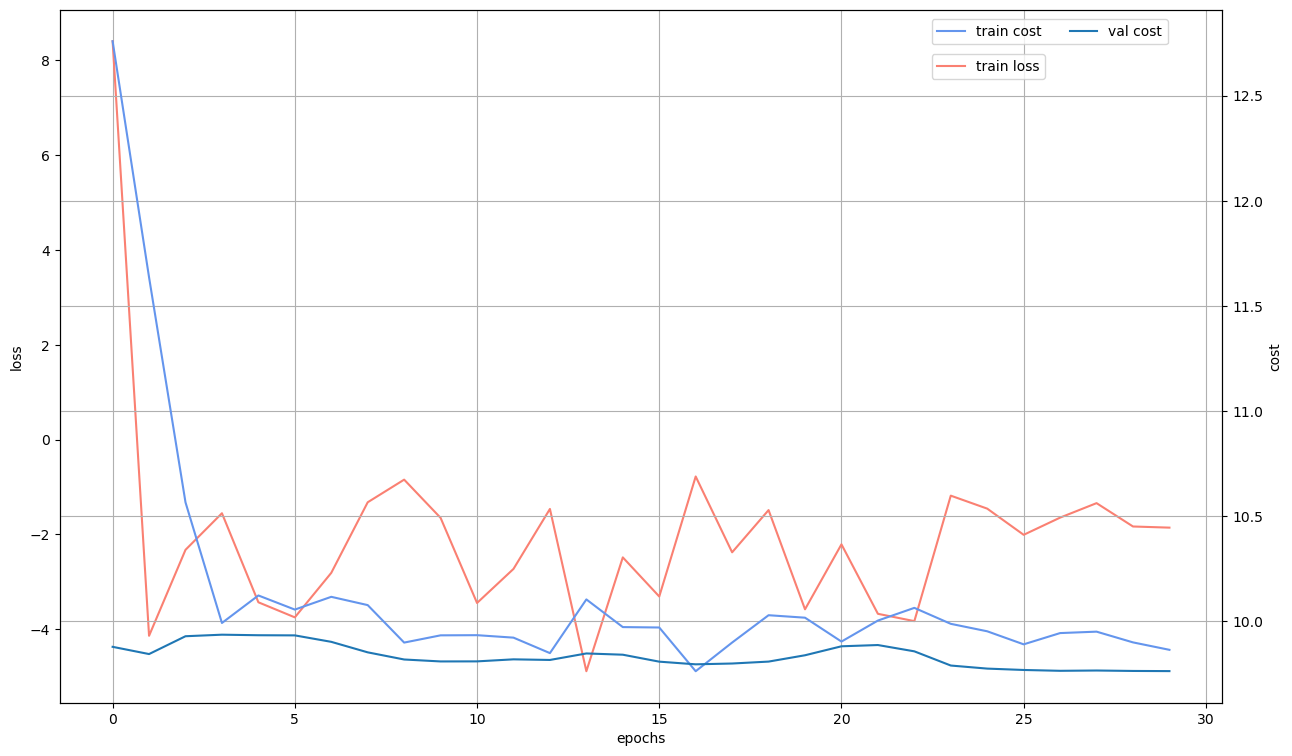

In [10]:
from train import train_model


optimizer          = optimizer
model_tf           = model
baseline           = baseline
validation_dataset = validation_dataset
samples            =  1_280_000 # 512
batch              = 32
val_batch_size     = 1_000
start_epoch        = 0
end_epoch          = 30
from_checkpoint    = False
grad_norm_clipping = 1.0
batch_verbose      = 1_000
graph_size         = graph_size
filename           = filename

train_model(optimizer =optimizer,
            model_tf = model_tf,
            baseline = baseline,
            validation_dataset = validation_dataset,
            samples = samples,
            batch = batch,
            val_batch_size = val_batch_size,
            start_epoch = start_epoch,
            end_epoch = end_epoch,
            from_checkpoint = from_checkpoint,
            grad_norm_clipping = grad_norm_clipping,
            batch_verbose = batch_verbose,
            graph_size = graph_size,
            filename = filename
            )

In [11]:
model_tf.save_weights("checkpoints/AM-D_oct_17_20_nodes.ckp")